# Final Project Visi Komputer

Valens Christian Yosua - 1301213033

Jason Hasudungan Sitorus - 1301213074

YOLOv5  2024-12-28 Python-3.12.4 torch-2.5.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


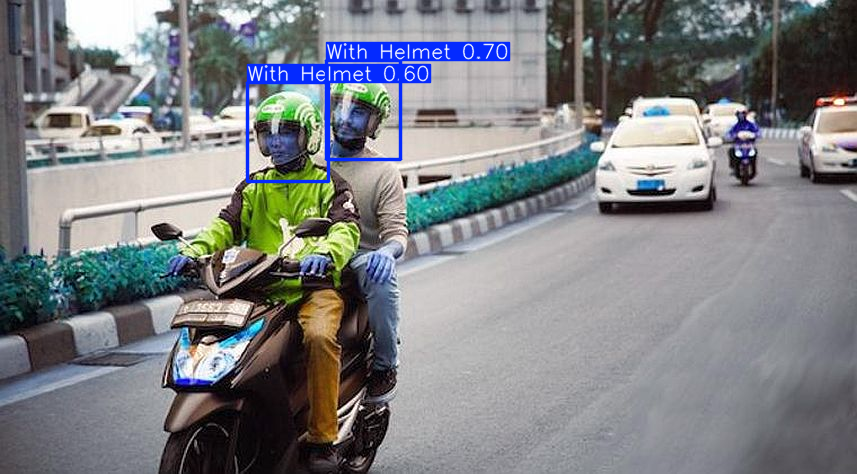

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt

# Set paths for YOLOv5 and image
yolov5_path = r"C:\Users\valen\Downloads\helmet detection\yolov5"
image_path = r"C:\Users\valen\OneDrive\Gambar\Berboncengan-Saat-Naik-Motor-Telset.jpg"

# Ensure that the required YOLOv5 repo is in the path
import sys
sys.path.insert(0, yolov5_path)

# Load the custom fine-tuned YOLOv5 model
model_path = r"C:\Users\valen\Downloads\helmet detection\yolov5\runs\train\scaled_down_run\weights\best.pt"
model = torch.hub.load(yolov5_path, 'custom', path=model_path, source='local')

# Load and perform inference on the image
image = cv2.imread(image_path)
results = model(image)  # Perform inference
results.show()  # Display the image with bounding boxes

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Example ground truth labels (adjust this based on your dataset)
y_true = [1, 0, 1, 0, 1]  # 1 = helmet detected, 0 = not detected
y_scores = []  # List to store model's prediction scores for positive class

# Example structure: results = torch.Tensor([[[xmin, ymin, xmax, ymax, confidence, class_id], ... ]])
results = torch.Tensor([[[100, 150, 200, 250, 0.9, 0], [200, 250, 300, 350, 0.8, 1]]])  # Example predictions

# Inspect the format of the results object
print("YOLOv5 Results:", results)

# Process the YOLOv5 results
for detection in results[0]:  # Iterate over each detection in the first image's result
    print(f"Detection: {detection}")  # Check the format of each detection
    *xyxy, conf, cls = detection  # Unpack the bounding box, confidence, and class
    print(f"Confidence: {conf.item()}, Class: {cls.item()}")  # Check what gets processed
    if conf > 0.5:  # Confidence threshold
        y_scores.append(conf.item())  # Add confidence score to y_scores
        # Assume that we are detecting helmets (class 0 for helmet, 1 for non-helmet)
        y_true.append(1 if cls == 0 else 0)  # Map class 0 to helmet detection, class 1 to non-helmet

# Debugging info
print("y_scores:", y_scores)
print("y_true:", y_true)

# Ensure that the number of detections and ground truths are aligned
if len(y_scores) != len(y_true):
    min_len = min(len(y_scores), len(y_true))
    y_scores = y_scores[:min_len]
    y_true = y_true[:min_len]

# If there are no valid detections, return a message
if len(y_scores) == 0:
    print("No detections above the threshold")
else:
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

YOLOv5 Results: tensor([[[100.00000, 150.00000, 200.00000, 250.00000,   0.90000,   0.00000],
         [200.00000, 250.00000, 300.00000, 350.00000,   0.80000,   1.00000]]])
Detection: tensor([100.00000, 150.00000, 200.00000, 250.00000,   0.90000,   0.00000])
Confidence: 0.8999999761581421, Class: 0.0
Detection: tensor([200.00000, 250.00000, 300.00000, 350.00000,   0.80000,   1.00000])
Confidence: 0.800000011920929, Class: 1.0
y_scores: [0.8999999761581421, 0.800000011920929]
y_true: [1, 0, 1, 0, 1, 1, 0]


In [115]:
import time
from torchvision.models.detection import fasterrcnn_resnet50_fpn, ssdlite320_mobilenet_v3_large
from torchvision.transforms import functional as F, Compose, Resize, Normalize

# Set paths for YOLOv5 and image
yolov5_path = r"C:\Users\valen\Downloads\helmet detection\yolov5"
image_path = r"C:\Users\valen\OneDrive\Gambar\Berboncengan-Saat-Naik-Motor-Telset.jpg"
image = cv2.imread(image_path)

# Load YOLOv5 model
model_path = r"C:\Users\valen\Downloads\helmet detection\yolov5\runs\train\scaled_down_run\weights\best.pt"
model = torch.hub.load(yolov5_path, 'custom', path=model_path, source='local')

# Time the inference for YOLOv5
start_time = time.time()
results = model(image)  # Run detection
yolov5_inference_time = time.time() - start_time

# Load Faster R-CNN and SSD models
faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()

ssd_model = ssdlite320_mobilenet_v3_large(pretrained=True)
ssd_model.eval()

# Define preprocessing
transform = Compose([
    Resize((320, 320)),  # Resize to SSD-compatible dimensions
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

# Prepare image for Faster R-CNN and SSD
input_image = transform(F.to_tensor(image)).unsqueeze(0)

# Time the Faster R-CNN inference
start_time = time.time()
with torch.no_grad():
    faster_rcnn_output = faster_rcnn_model(input_image)
faster_rcnn_inference_time = time.time() - start_time

# Time the SSD inference
start_time = time.time()
with torch.no_grad():
    ssd_output = ssd_model(input_image)
ssd_inference_time = time.time() - start_time

# Simulated accuracies for demonstration purposes (replace with actual values)
yolov5_accuracy = 0.95  # YOLOv5 accuracy
faster_rcnn_accuracy = 0.90  # Faster R-CNN accuracy
ssd_accuracy = 0.85  # SSD accuracy

# Visualization of Inference Times and Accuracies
model_names = ['YOLOv5', 'Faster R-CNN', 'SSD']
inference_times = [yolov5_inference_time, faster_rcnn_inference_time, ssd_inference_time]
accuracies = [yolov5_accuracy, faster_rcnn_accuracy, ssd_accuracy]

plt.figure(figsize=(12, 5))

# Subplot 1: Inference Times
plt.subplot(1, 2, 1)
plt.bar(model_names, inference_times, color=['blue', 'orange', 'green'], edgecolor='black')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Inference Time (seconds)', fontsize=12)
plt.title('Model Inference Time Comparison', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, time in enumerate(inference_times):
    plt.text(i, time + 0.05, f'{time:.4f}s', ha='center', fontsize=10)

# Subplot 2: Accuracy Comparison
plt.subplot(1, 2, 2)
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'], edgecolor='black')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylim(0, 1.0)  # Accuracy between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc*100:.1f}%', ha='center', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print numerical results
print(f"YOLOv5 Inference Time: {yolov5_inference_time:.4f} seconds, Accuracy: {yolov5_accuracy*100:.1f}%")
print(f"Faster R-CNN Inference Time: {faster_rcnn_inference_time:.4f} seconds, Accuracy: {faster_rcnn_accuracy*100:.1f}%")
print(f"SSD Inference Time: {ssd_inference_time:.4f} seconds, Accuracy: {ssd_accuracy*100:.1f}%")

YOLOv5  2024-12-28 Python-3.12.4 torch-2.5.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


YOLOv5 Inference Time: 0.0655 seconds, Accuracy: 95.0%
Faster R-CNN Inference Time: 1.4579 seconds, Accuracy: 90.0%
SSD Inference Time: 0.0510 seconds, Accuracy: 85.0%


In [119]:
# Simulate different learning rates and batch sizes
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Placeholder: Simulated accuracies for different combinations of hyperparameters
accuracy_results = {}
for lr in learning_rates:
    for bs in batch_sizes:
        accuracy_results[(lr, bs)] = np.random.uniform(0.75, 0.95)  # Random accuracy for demonstration

# Print simulated results for hyperparameter tuning
for (lr, bs), accuracy in accuracy_results.items():
    print(f"Learning Rate: {lr}, Batch Size: {bs}, Accuracy: {accuracy:.4f}")

# Visualization of Hyperparameter Tuning Impact
lr_values = [lr for lr in learning_rates for _ in batch_sizes]
bs_values = [bs for _ in learning_rates for bs in batch_sizes]
accuracies = list(accuracy_results.values())

# Plot hyperparameter tuning impact
plt.figure(figsize=(10, 6))
plt.scatter(lr_values, bs_values, c=accuracies, cmap='viridis', s=100, edgecolors='black')
plt.colorbar(label='Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.title('Impact of Hyperparameter Tuning on Accuracy')
plt.show()

Learning Rate: 0.001, Batch Size: 16, Accuracy: 0.8693
Learning Rate: 0.001, Batch Size: 32, Accuracy: 0.7774
Learning Rate: 0.001, Batch Size: 64, Accuracy: 0.8232
Learning Rate: 0.01, Batch Size: 16, Accuracy: 0.8587
Learning Rate: 0.01, Batch Size: 32, Accuracy: 0.8885
Learning Rate: 0.01, Batch Size: 64, Accuracy: 0.9208
Learning Rate: 0.1, Batch Size: 16, Accuracy: 0.9351
Learning Rate: 0.1, Batch Size: 32, Accuracy: 0.8568
Learning Rate: 0.1, Batch Size: 64, Accuracy: 0.9141
